# Parameter identification on the Lorenz system ($\sigma=10,\rho=28,\beta=8/3$)


# Combined Bachelor Thesis (NS-320B), June 2022
## Mathematics & Physics and Astronomy
*'Applying Physics-informed Neural Networks to Chaotic Systems of Ordinary Differential Equations'*

**Author:** Martijn Sebastiaan Brouwer (6859488)

**Mathematics supervisors:** prof. dr. ir. C.W. Oosterlee

**Physics supervisor:** dr. J. de Graaf

**PhD supervisor:** B. Negyesi

## Regression ANN
### The fitting of the ANN on the RK4 data of the Lorenz system

In [ ]:
# Expected runtime: epoch =    999  epoch loss = 7.04254913  time: 0:00:07.947769  s,r,b = 9.977880477905273, 28.003597259521484, 2.668961524963379
def parameter_identification():
    # takes in a module and applies the specified weight initialization
    def weights_init_xavier_rule(m):
      classname = m.__class__.__name__
      # for every Linear layer in a model
      if classname.find('Linear') != -1:
          torch.nn.init.xavier_normal_(m.weight)
          m.bias.data.fill_(0)

    class OdeNet(nn.Module):
        def __init__(self, t, ode_layers, activation_fun=nn.Tanh):
            super(OdeNet, self).__init__()

            self.act_fun = activation_fun()

            self.hidden_layers = [nn.Linear(ode_layers[0], ode_layers[1])]
            for idx, width in enumerate(ode_layers[1:-1]):
              if idx < (len(ode_layers[1:-1]) - 1):
                self.hidden_layers.append(nn.Linear(width, ode_layers[idx + 2]))

            self.output_layer = nn.Linear(ode_layers[-2], ode_layers[-1]) 

            self.fnn = self.layers()

        def forward(self, t):
            ode = self.fnn(t)
            return ode

        def layers(self):
            modules = []
            for idx, layer in enumerate(self.hidden_layers):
                modules.append(layer)
                modules.append(self.act_fun)
            modules.append(self.output_layer)
            return nn.Sequential(*modules)

    # (Hyper)parameters of the training -------------------------------------------
    ode_layers = [1, 100,100, 7]
    n = 1000
    tf = 3.0
    loss_ode_hist = [] #history files
    sigma_hist = []
    rho_hist = []
    beta_hist = []
    intermediate = 100
    iterations = 1000
    e = 0

    t = torch.linspace(0,tf,n).view(-1,1).requires_grad_(True) #Time-list used for obtaining regressed data
    model_ode = OdeNet(t, ode_layers)
    model_ode.apply(weights_init_xavier_rule)
    for i in range(len(ode_layers)-2):
      model_ode.hidden_layers[i].apply(weights_init_xavier_rule)
    ode_optimizer = torch.optim.Adam(model_ode.parameters(), lr=0.001)
    idn_u_pred = model.forward(t)
    xhat,yhat,zhat = idn_u_pred[:,0],idn_u_pred[:,1],idn_u_pred[:,2]
    xhat,yhat,zhat = xhat.view(-1,1),yhat.view(-1,1),zhat.view(-1,1)
    xhat_t = torch.autograd.grad(xhat, t, torch.ones_like(xhat), create_graph=True)[0]
    yhat_t = torch.autograd.grad(yhat, t, torch.ones_like(yhat), create_graph=True)[0]
    zhat_t = torch.autograd.grad(zhat, t, torch.ones_like(zhat), create_graph=True)[0]

    for i in range(iterations): #Loop over the iterations
        ode_optimizer.zero_grad()
        idn_ode_pred = model_ode.forward(t)

        sigma_pred,rho_pred,beta_pred = idn_ode_pred[:,0],idn_ode_pred[:,1],idn_ode_pred[:,2]
        sigma_pred,rho_pred,beta_pred = torch.mean(sigma_pred),torch.mean(rho_pred),torch.mean(beta_pred)
        physics_x = xhat_t - sigma_pred*(yhat-xhat)
        physics_y = yhat_t - xhat*(rho_pred - zhat) + yhat
        physics_z = zhat_t - xhat*yhat + beta_pred*zhat
        idn_ode_loss = torch.mean(torch.square(physics_x) + torch.square(physics_y) + torch.square(physics_z))

        idn_ode_loss.backward(retain_graph=True)
        ode_optimizer.step()

        idn_ode_loss = idn_ode_loss.detach() #This prevents the RAM from blowing up due to the retain_graph=True
        sigma_pred,rho_pred,beta_pred = sigma_pred.detach(),rho_pred.detach(),beta_pred.detach()

        loss_ode_hist.append(idn_ode_loss)
        sigma_hist.append(sigma_pred)
        rho_hist.append(rho_pred)
        beta_hist.append(beta_pred)

        if i%(intermediate) == 0:
            print("epoch = %6d" % i, end="")
            print("  epoch loss = %10.8f" % idn_ode_loss, end="")
            print("  time: {}".format(datetime.now() - time), end="")
            print("  s,r,b = {}, {}, {}".format(sigma_pred,rho_pred,beta_pred), end="")
            print("\n")

    print("epoch = %6d" % i, end="")
    print("  epoch loss = %10.8f" % idn_ode_loss, end="")
    print("  time: {}".format(datetime.now() - time), end="")
    print("  s,r,b = {}, {}, {}".format(sigma_pred,rho_pred,beta_pred), end="")
    print("\n")
    torch.save(model_ode.state_dict(), 'ANN_model_ode_weights.pth')
    return idn_ode_loss,sigma_pred,rho_pred,beta_pred

In [ ]:
# Expected runtime: 0:36:40.807232, epochs = 145.000
!mkdir plots
!mkdir plots_x
!mkdir plots_y
!mkdir plots_z

from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import warnings
from datetime import datetime
time = datetime.now()

warnings.simplefilter(action='ignore', category=FutureWarning)
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
torch.manual_seed(12345)
np.random.seed(12345)

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

#=============================================================================
#============================  Definitions  ==================================
#=============================================================================
# Fully Connected Network ----------------------------------------------------
class FCN(nn.Module): 
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh #Specify the used activation function
        self.fc1 = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN), activation()]) #Input to first hidden layer
        self.fc2 = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_HIDDEN, N_HIDDEN), activation()]) for _ in range(N_LAYERS-1)]) #Going through the remaining hidden layers
        self.fc3 = nn.Linear(N_HIDDEN, N_OUTPUT) #Last hidden layer to output layer

    def forward(self, *args):
        if len(args) == 1: #When multiple initial conditions are specified, this will provide the correct shape. 
            x = args[0]
        elif len(np.shape(args[0])) <= 1:
            x = torch.FloatTensor([*args]).T
        else:
            x = torch.FloatTensor(torch.cat([*args], 1))

        x = self.fc1(x) #Going to the layers
        x = self.fc2(x)
        x = self.fc3(x)
        return x

# Runge Kutta fourth order method ---------------------------------------------
def RungeKutta(dxdt,dydt,dzdt, x0,y0,z0, ti,tf,n): # Specify derivatives, initial conditions and time
    h = tf/n #Stepsize
    xl,yl,zl = n*[0],n*[0],n*[0] #Create lists for output
    xl[0],yl[0],zl[0] = x0,y0,z0 #First element in outputlist is initial condition
    for i in range(1,n): #Loop over steps while skipping the first one due to the initial condition
        x,y,z = xl[i-1],yl[i-1],zl[i-1]
        #Going through the four RK4 equations:
        k1x,k1y,k1z = (h*f(x,y,z)    for f in (dxdt,dydt,dzdt))
        xs,ys,zs    = (r + 0.5*kr    for r,kr in zip((x,y,z),(k1x,k1y,k1z,h)))
        k2x,k2y,k2z = (h*f(xs,ys,zs) for f in (dxdt,dydt,dzdt))
        xs,ys,zs    = (r + 0.5*kr    for r,kr in zip((x,y,z),(k2x,k2y,k2z,h)))
        k3x,k3y,k3z = (h*f(xs,ys,zs) for f in (dxdt,dydt,dzdt))
        xs,ys,zs    = (r + kr        for r,kr in zip((x,y,z),(k3x,k3y,k3z,h)))
        k4x,k4y,k4z = (h*f(xs,ys,zs) for f in (dxdt,dydt,dzdt))
        #Update last next value in output list:
        xl[i],yl[i],zl[i] = (r + (k1r + 2*k2r + 2*k3r + k4r)/6 for r,k1r,k2r,k3r,k4r in 
                zip((x,y,z),(k1x,k1y,k1z),(k2x,k2y,k2z),(k3x,k3y,k3z),(k4x,k4y,k4z)))
    return xl,yl,zl

# Plotting of both the RK4 and regression ANN solution in 3D ------------------
def plot_result(x,y,z, x0,y0,z0, xh,yh,zh):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(x,y,z, color="black", linewidth=1, alpha=0.8, label="RK4 approximation")
    ax.plot(xh,yh,zh, color="tab:blue", linewidth=2, alpha=0.7, label="ANN prediction")
    ax.scatter(x0, y0, z0, s=60, color="tab:orange", alpha=0.4, label='Initial condition')
    l = plt.legend(loc=(1.1,0.45), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    ax.text2D(0.11, 0.07, "Training step: %i"%(i+1), fontsize="x-large", color="k")
    ax.text2D(0.11, 0.05, "Loss: {:.2e}".format(loss), fontsize="x-large", color="k")
    ax.text2D(0.11, -0.03, "Learning rate: %.0E"%(lr), fontsize="x-large", color="k")
    ax.text2D(0.11, -0.05, "Hidden layers: ({}x{})".format(N_LAYERS, N_HIDDEN), fontsize="x-large", color="k")
    ax.text2D(0.11, -0.07, "Optimizer: Adam", fontsize="x-large", color="k")
    ax.text2D(0.11, -0.09, "$t_f$ = {:.2f}, $\\alpha$ = {:.1e}, $t_u$ = {:.1e}".format(tf, alpha, update_t), fontsize="x-large", color="k")
    ax.text2D(0.11, -0.11, "($\\sigma$,$\\rho$,$\\beta$) = ({},{},8/3) and ($x_0$,$y_0$,$z_0$) = ({},{},{})".format(sigma,rho,x0,y0,z0), fontsize="x-large", color="k")
    ax.set_xlabel('$x$', fontsize="x-large")
    ax.set_ylabel('$y$', fontsize="x-large")
    ax.set_zlabel('$z$', fontsize="x-large")

# Plotting of both the RK4 and regression ANN solution in 2D ------------------
def plot2D(t,exact, t_pred,pred, init,axis):
    plt.figure()
    plt.plot(t,exact, color="grey", linewidth=2, alpha=0.8, label="RK4 approximation")
    plt.plot(t_pred,pred, color="tab:blue", linewidth=2, alpha=0.7, label="ANN prediction")
    plt.scatter(t[0],init, s=60, color="tab:orange", alpha=0.4, label='Training data')
    l = plt.legend(loc=(1.05,0.425), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.annotate("Training step: %i"%(i+1),xy=(1.05, 0.87),xycoords='axes fraction',fontsize="x-large",color="k")
    plt.annotate("Loss: {:.2e}".format(loss),xy=(1.05, 0.77),xycoords='axes fraction',fontsize="x-large",color="k")
    plt.annotate("Learning rate: %.0E"%(lr),xy=(1.05, 0.35),xycoords='axes fraction',fontsize="x-large",color="k")
    plt.annotate("Hidden layers: ({}x{})".format(N_LAYERS, N_HIDDEN),xy=(1.05, 0.25),xycoords='axes fraction',fontsize="x-large",color="k")
    plt.annotate("Optimizer: Adam",xy=(1.05, 0.15),xycoords='axes fraction',fontsize="x-large",color="k")
    plt.annotate("$t_f$ = {:.2f}, $\\alpha$ = {:.1e}, $t_u$ = {:.1e}".format(tf, alpha, update_t),xy=(1.05, 0.05),xycoords='axes fraction',fontsize="x-large",color="k")
    plt.annotate("($\\sigma$,$\\rho$,$\\beta$) = ({},{},8/3) and ($x_0$,$y_0$,$z_0$) = ({},{},{})".format(sigma,rho,x0,y0,z0),xy=(1.05, -0.05),xycoords='axes fraction',fontsize="x-large",color="k")
    plt.ylabel('${}$'.format(axis), fontsize="x-large")
    plt.xlabel('Timestep $t$', fontsize="x-large")

# Used to create a iteratively gif-animation of the convergence ---------------
def save_gif(outfile, files, fps=5, loop=0):
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)


#=============================================================================
#============================  Parameters  ===================================
#=============================================================================
# Lorenz system parameters ---------------------------------------------------
x0,y0,z0 = 10,10,10 #Initial conditions
sigma = 10          #Parameters of system:
rho = 28
beta = 8/3
ti = 0              #Initial time
tf = 0.25           #Starting final time (without update)
n = 1000            #Steps taken between ti and tf
h = tf/n            #Stepsize of each step of n

# ANN parameters --------------------------------------------------------------
lr = 1e-3           #Learning rate
N_HIDDEN = 50       #Amount of hidden layers
N_LAYERS = 4        #Amount of neurons in hidden layers
alpha = 0.01        #Threshold value for updating tf with update_t
update_t = 0.25     #Update value for tf after reaching threshold
intermediate = 2500 #Used as stepsize for intermediate plotting

# Lorenz differential equation definitions ------------------------------------
def dxdt_def(x,y,z): return -sigma*x + sigma*y
def dydt_def(x,y,z): return -x*z + rho*x - y
def dzdt_def(x,y,z): return x*y - beta*z


#=============================================================================
#=========================  Identification ANN  ==============================
#=============================================================================
# Define the model -----------------------------------------------------------
model = FCN(1,3,N_HIDDEN,N_LAYERS) #Create a network with the specified hidden layers and neurons
optimizer = torch.optim.Adam(model.parameters(),lr=lr) #Specify the optimizer using the specified the learning rate

loss_hist = []            #To keep track of the loss history
tf_list = []              #List which will update the final time using TEM
files,files_x,files_y,files_z = [],[],[],[] #Create empty files for the intermediate results for the animation
iterations = []           #To keep track of the iterations
i = 0                     #Starting iteration because a while loop is used
sigma_list,rho_list,beta_list,parameter_loss = [],[],[],[]
while tf < 7.6: #Loop over the iterations (and stop when tf = 3.0 is reached and empirically converged)
    t_physics = torch.linspace(ti,tf,n).view(-1,1).requires_grad_(True) #Time-tensor used in loss training
    x,y,z = torch.FloatTensor(RungeKutta(dxdt_def,dydt_def,dzdt_def, x0,y0,z0, ti,tf,n))

    optimizer.zero_grad() #Set gradients of all optimized tensors to zero

    #Calculation of the loss:
    p = model(t_physics)
    px,py,pz = p[:,0],p[:,1],p[:,2]
    physics_x = px - x
    physics_y = py - y
    physics_z = pz - z
    loss = torch.mean(physics_x**2 + physics_y**2 + physics_z**2) #Total loss is the MSE of above residuals

    loss.backward()  #parameter.grad += dloss/d(parameter), for every parameter (the weight/bias matrices)
    optimizer.step() #parameter += -lr * parameter.grad
    
    if loss < alpha: #When dynamic loss2 is below threshold of alpha, add update_t to current tf (TEM)
        tf_list.append(tf + update_t)
        idn_ode_loss,sigma_pred,rho_pred,beta_pred = parameter_identification()
        parameter_loss.append(idn_ode_loss)
        sigma_list.append(sigma_pred)
        rho_list.append(rho_pred)
        beta_list.append(beta_pred)
    if len(tf_list) > 0: #For updating the final time in the system
        tf = tf_list[-1]
        h = tf/n

    i += 1           #To keep track of the iterations
    iterations.append(i)
    loss = loss.detach()  #This prevents the RAM memory from getting full. 
    loss_hist.append(loss)

    if (iterations[-1]+1)%intermediate == 0: #Plot and save intermediate results
        t_physics = torch.linspace(ti,tf,n).view(-1,1).requires_grad_(True)
        p = model(t_physics)
        print("ANN, iteration: {}, loss: {}, time: {}".format(i+1,loss,datetime.now() - time))
        m1 = torch.squeeze(p.detach())
        xh,yh,zh = m1[:,0],m1[:,1],m1[:,2] #x,y,z results with:
        th = torch.linspace(ti,tf,n).view(-1,1) #corresponding times
        x,y,z = torch.FloatTensor(RungeKutta(dxdt_def,dydt_def,dzdt_def, x0,y0,z0, ti,float('%.2g'%(tf+0.25)),n)) #RK4 results with:
        t = torch.linspace(ti,tf+0.25,n).view(-1,1) #corresponding times that stays +0.25 timesteps above the ANN regressed result. 
        
        plot_result(x,y,z, x0,y0,z0, xh,yh,zh) #3D plot 
        file = "plots/regression_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        plt.show() #Show plots
    
torch.save(model.state_dict(), 'ANN_model_weights.pth')

#Creating gif-animations:
save_gif("regression.gif", files, fps=20, loop=0)

In [ ]:
alpha = 0.01
0.25 epoch =    999  epoch loss = 2382.95385742  time: 0:02:52.854950  s,r,b = 0.29379522800445557, 36.33419418334961, -0.21592473983764648
0.50 epoch =    999  epoch loss = 938.10894775   time: 0:03:16.162480  s,r,b = 7.925734996795654, 24.851926803588867, 1.5430362224578857
0.75 epoch =    999  epoch loss = 3731.33203125  time: 0:04:07.233490  s,r,b = 2.5609312057495117, 25.171545028686523, 6.189502716064453
1.00 epoch =    999  epoch loss = 1758.41723633  time: 0:05:07.688750  s,r,b = 3.1486220359802246, 28.406902313232422, 0.9609259963035583
1.25 epoch =    999  epoch loss = 923.75335693   time: 0:05:43.563097  s,r,b = 8.226239204406738, 26.821462631225586, 2.1832706928253174
1.50 epoch =    999  epoch loss = 7774.95458984  time: 0:07:39.660077  s,r,b = 3.6462314128875732, 25.861583709716797, 5.7745866775512695
1.75 epoch =    999  epoch loss = 1416.77026367  time: 0:09:09.710438  s,r,b = 7.568877696990967, 27.690631866455078, 1.7664381265640259
2.00 epoch =    999  epoch loss = 378.55798340   time: 0:09:29.320883  s,r,b = 10.017578125, 27.779569625854492, 2.4790565967559814
2.25 epoch =    999  epoch loss = 1646.11889648  time: 0:10:03.685430  s,r,b = 8.952779769897461, 26.5019474029541, 2.709542989730835
2.50 epoch =    999  epoch loss = 7322.89550781  time: 0:12:58.654142  s,r,b = 9.973597526550293, 32.08173370361328, 4.459659576416016
2.75 epoch =    999  epoch loss = 201.32081604   time: 0:14:25.391313  s,r,b = 9.945901870727539, 27.929140090942383, 2.6147007942199707
3.00 epoch =    999  epoch loss = 41.24580765    time: 0:15:51.792983  s,r,b = 9.929581642150879, 27.981653213500977, 2.666916847229004
3.25 epoch =    999  epoch loss = 37.33364105    time: 0:17:08.099563  s,r,b = 10.009952545166016, 27.963369369506836, 2.6691014766693115
3.50 epoch =    999  epoch loss = 23.26329613    time: 0:18:02.859100  s,r,b = 10.001747131347656, 27.980743408203125, 2.66807222366333
3.75 epoch =    999  epoch loss = 18.35911369    time: 0:20:25.965959  s,r,b = 9.987308502197266, 27.98800277709961, 2.667830467224121
4.00 epoch =    999  epoch loss = 15.58909416    time: 0:22:28.643986  s,r,b = 9.986749649047852, 28.000751495361328, 2.665583610534668
4.25 epoch =    999  epoch loss = 12.79624939    time: 0:23:34.821013  s,r,b = 9.991552352905273, 28.00308609008789, 2.666750192642212
4.50 epoch =    999  epoch loss = 13.76271439    time: 0:27:46.939339  s,r,b = 9.998437881469727, 27.99668312072754, 2.666140556335449
4.75 epoch =    999  epoch loss = 8.40909576     time: 0:31:12.086828  s,r,b = 9.986687660217285, 28.00796127319336, 2.6673145294189453
5.00 epoch =    999  epoch loss = 9.11951923     time: 0:32:57.024787  s,r,b = 9.988369941711426, 28.003522872924805, 2.6679210662841797
5.25 epoch =    999  epoch loss = 8.10656166     time: 0:44:13.718131  s,r,b = 9.99167537689209, 27.993722915649414, 2.6671314239501953
5.50 epoch =    999  epoch loss = 6.92061043     time: 0:53:05.795419  s,r,b = 9.987269401550293, 27.999052047729492, 2.6675353050231934
5.75 epoch =    999  epoch loss = 8.17535877     time: 0:57:40.718350  s,r,b = 9.988048553466797, 27.99159049987793, 2.6676108837127686
6.00 epoch =    999  epoch loss = 4.24923754     time: 1:54:58.414387  s,r,b = 9.989642143249512, 28.002824783325195, 2.6670634746551514
6.25 epoch =    999  epoch loss = 1.06920469     time: 2:26:50.483111  s,r,b = 9.989985466003418, 28.006574630737305, 2.666619062423706
6.50 epoch =    999  epoch loss = 6.97947454     time: 2:35:05.022216  s,r,b = 9.99015998840332, 27.994611740112305, 2.6665377616882324
6.75 epoch =    999  epoch loss = 43.52198792    time: 2:58:15.684912  s,r,b = 9.988991737365723, 27.992324829101562, 2.6655962467193604
7.00 epoch =    999  epoch loss = 2.58067465     time: 3:12:59.899811  s,r,b = 9.99034595489502, 28.001089096069336, 2.666309118270874

alpha = 0.001
0.25 epoch =    999  epoch loss = 2159.24804688  time: 0:03:06.849490  s,r,b = 0.3205312490463257, 35.4979248046875, -0.2286829799413681
0.5 epoch =    999  epoch loss = 1244.94616699  time: 0:04:10.769127  s,r,b = 8.233845710754395, 22.842435836791992, 2.0280072689056396
0.75 epoch =    999  epoch loss = 3834.59960938  time: 0:05:46.291231  s,r,b = 2.771568536758423, 25.736774444580078, 6.321140289306641
1.0 epoch =    999  epoch loss = 1738.75671387  time: 0:07:21.596640  s,r,b = 3.764641523361206, 28.616853713989258, 0.9254245758056641
1.25 epoch =    999  epoch loss = 1166.47705078  time: 0:08:14.440697  s,r,b = 8.273147583007812, 25.898183822631836, 2.335461378097534
1.5 epoch =    999  epoch loss = 7473.09179688  time: 0:09:57.712504  s,r,b = 3.9355342388153076, 26.62657928466797, 5.817582130432129
1.75 epoch =    999  epoch loss = 1829.81896973  time: 0:11:49.819457  s,r,b = 5.657272815704346, 27.499208450317383, 1.6864640712738037
2.0 epoch =    999  epoch loss = 200.59762573  time: 0:12:23.717291  s,r,b = 9.990280151367188, 27.922300338745117, 2.5433802604675293
2.25 epoch =    999  epoch loss = 2701.14746094  time: 0:14:07.097743  s,r,b = 7.905655860900879, 25.748394012451172, 2.7634501457214355
2.5 epoch =    999  epoch loss = 4604.59082031  time: 0:19:46.878388  s,r,b = 9.893217086791992, 30.940471649169922, 4.034419536590576
2.75 epoch =    999  epoch loss = 165.40789795  time: 0:22:31.323477  s,r,b = 9.941086769104004, 27.956897735595703, 2.6724491119384766
3.0 epoch =    999  epoch loss = 7.04254961  time: 0:36:44.591326  s,r,b = 9.977880477905273, 28.003597259521484, 2.6689612865448
3.25 epoch =    999  epoch loss = 3.48544621  time: 0:41:56.392398  s,r,b = 9.983969688415527, 28.00189208984375, 2.666628837585449
3.5 epoch =    999  epoch loss = 2.60898352  time: 0:45:40.680040  s,r,b = 9.9849271774292, 28.002771377563477, 2.666465997695923
3.75 epoch =    999  epoch loss = 1.38671339  time: 1:52:13.188765  s,r,b = 9.989422798156738, 28.002166748046875, 2.66675066947937
4.0 epoch =    999  epoch loss = 2.78919077  time: 2:45:08.589696  s,r,b = 9.990386009216309, 28.00454330444336, 2.666534423828125
4.25 epoch =    999  epoch loss = 1.11509919  time: 3:05:53.004291  s,r,b = 9.990853309631348, 28.002012252807617, 2.666900634765625
4.5 epoch =    999  epoch loss = 1.67051852  time: 4:58:12.830323  s,r,b = 9.990507125854492, 28.001129150390625, 2.666934013366699
4.75 epoch =    999  epoch loss = 3.43312454  time: 5:16:21.669476  s,r,b = 9.989041328430176, 28.001876831054688, 2.666971206665039
alpha = 0.0001
0.25 epoch =    999  epoch loss = 1847.89575195  time: 0:03:39.434002  s,r,b = 0.3821176290512085, 34.05291748046875, -0.24520856142044067
0.5 epoch =    999  epoch loss = 1194.25427246  time: 0:06:03.302819  s,r,b = 7.09465217590332, 23.091901779174805, 2.0608654022216797
0.75 epoch =    999  epoch loss = 3954.88525391  time: 0:07:16.588101  s,r,b = 3.079575538635254, 26.670297622680664, 6.479745864868164
1.0 epoch =    999  epoch loss = 1740.58996582  time: 0:10:15.028304  s,r,b = 3.881206512451172, 28.522401809692383, 0.9171748161315918
1.25 epoch =    999  epoch loss = 1225.66760254  time: 0:12:14.862839  s,r,b = 9.154293060302734, 25.382505416870117, 2.3198630809783936
1.5 epoch =    999  epoch loss = 8184.64013672  time: 0:15:38.577154  s,r,b = 4.313880443572998, 26.62465476989746, 5.977424621582031
1.75 epoch =    999  epoch loss = 1333.66918945  time: 0:20:11.251716  s,r,b = 7.141971111297607, 27.185501098632812, 1.945793867111206
2.0 epoch =    999  epoch loss = 253.93386841  time: 0:22:40.947541  s,r,b = 9.99077033996582, 27.85529327392578, 2.5341789722442627
2.25 epoch =    999  epoch loss = 2093.74194336  time: 0:27:41.477171  s,r,b = 7.851835250854492, 26.115901947021484, 2.754638195037842
2.5 epoch =    999  epoch loss = 6010.11181641  time: 0:45:14.973205  s,r,b = 9.33642864227295, 33.610809326171875, 3.799093246459961
2.75 epoch =    999  epoch loss = 132.55941772  time: 1:00:10.241128  s,r,b = 9.919923782348633, 27.95824432373047, 2.576725959777832
3.0 epoch =    999  epoch loss = 1.58497584  time: 1:33:17.300753  s,r,b = 9.985220909118652, 28.001100540161133, 2.667257308959961
3.25 epoch =    999  epoch loss = 0.94919932  time: 2:29:29.857958  s,r,b = 9.989940643310547, 28.00265121459961, 2.666827917098999
3.5 epoch =    999  epoch loss = 0.92829370  time: 2:44:36.886388  s,r,b = 9.989187240600586, 28.003582000732422, 2.6668763160705566

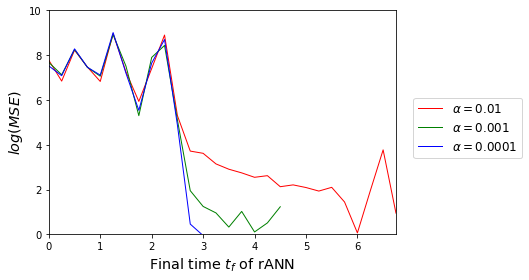

19


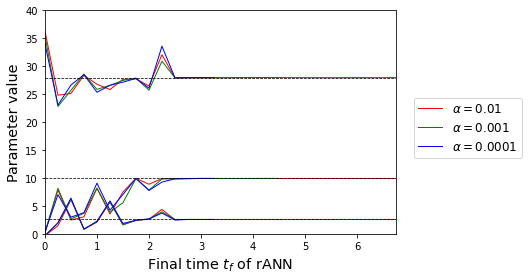

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
step_list = np.arange(0,7,0.25)
loss_alpha01 = [2382.95385742,938.10894775,3731.33203125,1758.41723633,923.75335693,7774.95458984,1416.77026367,378.55798340,1646.11889648,7322.89550781,201.32081604,41.24580765,37.33364105,23.26329613,18.35911369,15.58909416,12.79624939,13.76271439,8.40909576,9.11951923,8.10656166,6.92061043,8.17535877,4.24923754,1.06920469,6.97947454,43.52198792,2.58067465]
loss_alpha001 = [2159.24804688,1244.94616699,3834.59960938,1738.75671387,1166.47705078,7473.09179688,1829.81896973,200.59762573,2701.14746094,4604.59082031,165.40789795,7.04254961,3.48544621,2.60898352,1.38671339,2.78919077,1.11509919,1.67051852,3.43312454]
loss_alpha0001 = [1847.89575195,1194.25427246,3954.88525391,1740.58996582,1225.66760254,8184.64013672,1333.66918945,253.93386841,2093.74194336,6010.11181641,132.55941772,1.58497584,0.94919932,0.92829370]

parameters_alpha01 = np.array([[0.29379522800445557, 36.33419418334961, -0.21592473983764648],
[7.925734996795654, 24.851926803588867, 1.5430362224578857],
[2.5609312057495117, 25.171545028686523, 6.189502716064453],
[3.1486220359802246, 28.406902313232422, 0.9609259963035583],
[8.226239204406738, 26.821462631225586, 2.1832706928253174],
[3.6462314128875732, 25.861583709716797, 5.7745866775512695],
[7.568877696990967, 27.690631866455078, 1.7664381265640259],
[10.017578125, 27.779569625854492, 2.4790565967559814],
[8.952779769897461, 26.5019474029541, 2.709542989730835],
[9.973597526550293, 32.08173370361328, 4.459659576416016],
[9.945901870727539, 27.929140090942383, 2.6147007942199707],
[9.929581642150879, 27.981653213500977, 2.666916847229004],
[10.009952545166016, 27.963369369506836, 2.6691014766693115],
[10.001747131347656, 27.980743408203125, 2.66807222366333],
[9.987308502197266, 27.98800277709961, 2.667830467224121],
[9.986749649047852, 28.000751495361328, 2.665583610534668],
[9.991552352905273, 28.00308609008789, 2.666750192642212],
[9.998437881469727, 27.99668312072754, 2.666140556335449],
[9.986687660217285, 28.00796127319336, 2.6673145294189453],
[9.988369941711426, 28.003522872924805, 2.6679210662841797],
[9.99167537689209, 27.993722915649414, 2.6671314239501953],
[9.987269401550293, 27.999052047729492, 2.6675353050231934],
[9.988048553466797, 27.99159049987793, 2.6676108837127686],
[9.989642143249512, 28.002824783325195, 2.6670634746551514],
[9.989985466003418, 28.006574630737305, 2.666619062423706],
[9.99015998840332, 27.994611740112305, 2.6665377616882324],
[9.988991737365723, 27.992324829101562, 2.6655962467193604],
[9.99034595489502, 28.001089096069336, 2.666309118270874]])
parameters_alpha001 = np.array([[0.3205312490463257, 35.4979248046875, -0.2286829799413681],
[8.233845710754395, 22.842435836791992, 2.0280072689056396],
[2.771568536758423, 25.736774444580078, 6.321140289306641],
[3.764641523361206, 28.616853713989258, 0.9254245758056641],
[8.273147583007812, 25.898183822631836, 2.335461378097534],
[3.9355342388153076, 26.62657928466797, 5.817582130432129],
[5.657272815704346, 27.499208450317383, 1.6864640712738037],
[9.990280151367188, 27.922300338745117, 2.5433802604675293],
[7.905655860900879, 25.748394012451172, 2.7634501457214355],
[9.893217086791992, 30.940471649169922, 4.034419536590576],
[9.941086769104004, 27.956897735595703, 2.6724491119384766],
[9.977880477905273, 28.003597259521484, 2.6689612865448],
[9.983969688415527, 28.00189208984375, 2.666628837585449],
[9.9849271774292, 28.002771377563477, 2.666465997695923],
[9.989422798156738, 28.002166748046875, 2.66675066947937],
[9.990386009216309, 28.00454330444336, 2.666534423828125],
[9.990853309631348, 28.002012252807617, 2.666900634765625],
[9.990507125854492, 28.001129150390625, 2.666934013366699],
[9.989041328430176, 28.001876831054688, 2.666971206665039]])
parameters_alpha0001 = np.array([[0.3821176290512085, 34.05291748046875, -0.24520856142044067],
[7.09465217590332, 23.091901779174805, 2.0608654022216797],
[3.079575538635254, 26.670297622680664, 6.479745864868164],
[3.881206512451172, 28.522401809692383, 0.9171748161315918],
[9.154293060302734, 25.382505416870117, 2.3198630809783936],
[4.313880443572998, 26.62465476989746, 5.977424621582031],
[7.141971111297607, 27.185501098632812, 1.945793867111206],
[9.99077033996582, 27.85529327392578, 2.5341789722442627],
[7.851835250854492, 26.115901947021484, 2.754638195037842],
[9.33642864227295, 33.610809326171875, 3.799093246459961],
[9.919923782348633, 27.95824432373047, 2.576725959777832],
[9.985220909118652, 28.001100540161133, 2.667257308959961],
[9.989940643310547, 28.00265121459961, 2.666827917098999],
[9.989187240600586, 28.003582000732422, 2.6668763160705566]])

plt.figure(figsize=(7.5,4))
plt.plot(step_list[:len(loss_alpha01)], np.array(np.log(loss_alpha01)), 'r', lw=1, label='$\\alpha = 0.01$')
plt.plot(step_list[:len(loss_alpha001)], np.array(np.log(loss_alpha001)), 'g', lw=1, label='$\\alpha = 0.001$')
plt.plot(step_list[:len(loss_alpha0001)], np.array(np.log(loss_alpha0001)), 'b', lw=1, label='$\\alpha = 0.0001$')
plt.xlabel('Final time $t_f$ of rANN', fontsize='x-large')
plt.ylabel('$log(MSE)$', fontsize='x-large')
l = plt.legend(loc=(1.05,0.34), frameon=True, fontsize="large")
plt.setp(l.get_texts(), color="k")
plt.xlim(0,step_list[-1])
plt.ylim(0,10)
plt.tight_layout()
plt.savefig('Parameter_loss.png')
plt.show()

sigma01,rho01,beta01 = parameters_alpha01[:,0],parameters_alpha01[:,1],parameters_alpha01[:,2]
sigma001,rho001,beta001 = parameters_alpha001[:,0],parameters_alpha001[:,1],parameters_alpha001[:,2]
sigma0001,rho0001,beta0001 = parameters_alpha0001[:,0],parameters_alpha0001[:,1],parameters_alpha0001[:,2]
sigma,rho,beta = 10,28,8/3

plt.figure(figsize=(7.5,4))
plt.plot(step_list[:len(sigma01)], np.array(sigma01), 'r', linewidth=1, label="$\\alpha = 0.01$")
plt.plot(step_list[:len(rho01)], np.array(rho01), 'r', linewidth=1)
plt.plot(step_list[:len(beta01)], np.array(beta01), 'r', linewidth=1)
print(len(sigma001))
plt.plot(step_list[:len(sigma001)], np.array(sigma001), 'g', linewidth=1, label="$\\alpha = 0.001$")
plt.plot(step_list[:len(rho001)], np.array(rho001), 'g', linewidth=1)
plt.plot(step_list[:len(beta001)], np.array(beta001), 'g', linewidth=1)
plt.plot(step_list[:len(sigma0001)], np.array(sigma0001), 'b', linewidth=1, label="$\\alpha = 0.0001$")
plt.plot(step_list[:len(rho0001)], np.array(rho0001), 'b', linewidth=1)
plt.plot(step_list[:len(beta0001)], np.array(beta0001), 'b', linewidth=1)
plt.axhline(sigma, c='k', ls='--', linewidth=0.75)
plt.axhline(rho, c='k', ls='--', linewidth=0.75)
plt.axhline(beta, c='k', ls='--', linewidth=0.75)
l = plt.legend(loc=(1.05,0.34), frameon=True, fontsize="large")
plt.setp(l.get_texts(), color="k")
plt.xlim(0,step_list[-1])
plt.ylim(0,40)
plt.xlabel('Final time $t_f$ of rANN', fontsize='x-large')
plt.ylabel('Parameter value', fontsize='x-large')
plt.tight_layout()
plt.savefig('parameter_history_ode.png')
plt.show()

In [ ]:
plt.plot(np.array(np.log(loss_hist)), 'r', linewidth=0.5)
plt.xlabel('Iterations', fontsize='x-large')
plt.ylabel('$\\log(MSE)$', fontsize='x-large')
plt.xlim(0,iterations[-1])
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0)) #Scientific numbers on x-axis
plt.savefig('loss_history_ode3.png')
#plt.axhline(alpha, color='r--', lw=.5, alpha=.5)
plt.show()

In [ ]:
# Reloading from already saved models (not necessary) -------------------------
model = FCN(1,3,50,4)
model.load_state_dict(torch.load("ANN_model_weights7.5.pth"))
model.eval()

# model_ode = OdeNet(t, ode_layers)
# model_ode.load_state_dict(torch.load("ANN_model_ode_weights.pth"))
# model_ode.eval()

FCN(
  (fc1): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Tanh()
  )
  (fc2): Sequential(
    (0): Sequential(
      (0): Linear(in_features=50, out_features=50, bias=True)
      (1): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=50, out_features=50, bias=True)
      (1): Tanh()
    )
    (2): Sequential(
      (0): Linear(in_features=50, out_features=50, bias=True)
      (1): Tanh()
    )
  )
  (fc3): Linear(in_features=50, out_features=3, bias=True)
)

# Identification ANN
## The learning of the dynamics of the systems

In [ ]:
# epoch =    999  epoch loss = 7.04254913  time: 0:00:07.947769  s,r,b = 9.977880477905273, 28.003597259521484, 2.668961524963379 tf3
# epoch =    999  epoch loss = 1.29826224  time: 0:00:07.768540  s,r,b = 9.990242004394531, 28.00292205810547, 2.6666054725646973 tf8 0.01

time = datetime.now()
torch.manual_seed(12345)
np.random.seed(12345)

# takes in a module and applies the specified weight initialization
def weights_init_xavier_rule(m):
  classname = m.__class__.__name__
  # for every Linear layer in a model
  if classname.find('Linear') != -1:
      torch.nn.init.xavier_normal_(m.weight)
      m.bias.data.fill_(0)

class OdeNet(nn.Module):
    def __init__(self, t, ode_layers, activation_fun=nn.Tanh):
        super(OdeNet, self).__init__()

        self.act_fun = activation_fun()

        self.hidden_layers = [nn.Linear(ode_layers[0], ode_layers[1])]
        for idx, width in enumerate(ode_layers[1:-1]):
          if idx < (len(ode_layers[1:-1]) - 1):
            self.hidden_layers.append(nn.Linear(width, ode_layers[idx + 2]))

        self.output_layer = nn.Linear(ode_layers[-2], ode_layers[-1]) 

        self.fnn = self.layers()

    def forward(self, t):
        ode = self.fnn(t)
        return ode

    def layers(self):
        modules = []
        for idx, layer in enumerate(self.hidden_layers):
            modules.append(layer)
            modules.append(self.act_fun)
        modules.append(self.output_layer)
        return nn.Sequential(*modules)

# (Hyper)parameters of the training -------------------------------------------
ode_layers = [1, 100,100, 7]
n = 1000
tf = 3.0
loss_ode_hist = [] #history files
co1_hist = []
co2_hist = []
co3_hist = []
co4_hist = []
co5_hist = []
co6_hist = []
co7_hist = []
intermediate = 100
iterations = 10000
e = 0

t = torch.linspace(0,tf,n).view(-1,1).requires_grad_(True) #Time-list used for obtaining regressed data
model_ode = OdeNet(t, ode_layers)
model_ode.apply(weights_init_xavier_rule)
for i in range(len(ode_layers)-2):
  model_ode.hidden_layers[i].apply(weights_init_xavier_rule)
ode_optimizer = torch.optim.Adam(model_ode.parameters(), lr=0.001)
idn_u_pred = model.forward(t)
xhat,yhat,zhat = idn_u_pred[:,0],idn_u_pred[:,1],idn_u_pred[:,2]
xhat,yhat,zhat = xhat.view(-1,1),yhat.view(-1,1),zhat.view(-1,1)
xhat_t = torch.autograd.grad(xhat, t, torch.ones_like(xhat), create_graph=True)[0]
yhat_t = torch.autograd.grad(yhat, t, torch.ones_like(yhat), create_graph=True)[0]
zhat_t = torch.autograd.grad(zhat, t, torch.ones_like(zhat), create_graph=True)[0]

for i in range(iterations): #Loop over the iterations
    ode_optimizer.zero_grad()
    idn_ode_pred = model_ode.forward(t)

    co1,co2,co3,co4,co5,co6,co7 = idn_ode_pred[:,0],idn_ode_pred[:,1],idn_ode_pred[:,2],idn_ode_pred[:,3],idn_ode_pred[:,4],idn_ode_pred[:,5],idn_ode_pred[:,6]
    co1,co2,co3,co4,co5,co6,co7 = torch.mean(co1),torch.mean(co2),torch.mean(co3),torch.mean(co4),torch.mean(co5),torch.mean(co6),torch.mean(co7)
    physics_x = co1*yhat - co2*xhat - xhat_t
    physics_y = co3*xhat - co4*xhat*zhat - co5*yhat - yhat_t
    physics_z = co6*xhat*yhat - co7*zhat - zhat_t
    idn_ode_loss = torch.mean(torch.square(physics_x) + torch.square(physics_y) + torch.square(physics_z))

    idn_ode_loss.backward(retain_graph=True)
    ode_optimizer.step()

    idn_ode_loss = idn_ode_loss.detach() #This prevents the RAM from blowing up due to the retain_graph=True
    co1,co2,co3,co4,co5,co6,co7 = co1.detach(),co2.detach(),co3.detach(),co4.detach(),co5.detach(),co6.detach(),co7.detach()

    loss_ode_hist.append(idn_ode_loss)
    co1_hist.append(co1)
    co2_hist.append(co2)
    co3_hist.append(co3)
    co4_hist.append(co4)
    co5_hist.append(co5)
    co6_hist.append(co6)
    co7_hist.append(co7)


    if i%(intermediate) == 0:
        print("epoch = %6d" % i, end="")
        print("  epoch loss = %10.8f" % idn_ode_loss, end="")
        print("  time: {}".format(datetime.now() - time), end="")
        print("  coefficients = {}, {}, {}, {}, {}, {}, {}".format(co1,co2,co3,co4,co5,co6,co7), end="")
        print("\n")

print("epoch = %6d" % i, end="")
print("  epoch loss = %10.8f" % idn_ode_loss, end="")
print("  time: {}".format(datetime.now() - time), end="")
print("\n")
torch.save(model_ode.state_dict(), 'ANN_model_ode_weights.pth')

epoch =      0  epoch loss = 22817.09960938  time: 0:00:00.047341  coefficients = 0.04563530534505844, -0.3731591999530792, -0.1869036853313446, 0.18687014281749725, 0.01361778099089861, 0.01691018044948578, 0.1359795182943344

epoch =    100  epoch loss = 2095.57617188  time: 0:00:01.792231  coefficients = 4.235351085662842, 3.7571771144866943, 2.442575693130493, -0.3637111485004425, -4.120497226715088, 1.0156526565551758, 2.772095203399658

epoch =    200  epoch loss = 763.40905762  time: 0:00:03.051675  coefficients = 8.982721328735352, 8.89457893371582, 6.182236671447754, -0.5339310169219971, -6.302053928375244, 1.0037286281585693, 2.6757187843322754

epoch =    300  epoch loss = 543.73376465  time: 0:00:04.236823  coefficients = 10.100398063659668, 10.106144905090332, 9.236227035522461, -0.5951248407363892, -5.11436653137207, 1.0034370422363281, 2.672410249710083

epoch =    400  epoch loss = 351.06063843  time: 0:00:05.391297  coefficients = 10.181506156921387, 10.196075439453125

## Plot of the loss during the iterations of the ANN identifier

In [ ]:
plt.plot(np.array(sigma_hist), 'r', linewidth=1, label="$\\sigma$")
plt.plot(np.array(rho_hist), 'b', linewidth=1, label="$\\rho$")
plt.plot(np.array(beta_hist), 'g', linewidth=1, label="$\\beta$")
plt.axhline(sigma, c='r', ls='--', linewidth=0.75)
plt.axhline(rho, c='b', ls='--', linewidth=0.75)
plt.axhline(beta, c='g', ls='--', linewidth=0.75)
l = plt.legend(loc=(1.1,0.34), frameon=True, fontsize="large")
plt.setp(l.get_texts(), color="k")
plt.xlabel('Iterations', fontsize='x-large')
plt.ylabel('Parameter value', fontsize='x-large')
plt.xlim(0,iterations)
plt.ylim(0,30)
plt.savefig('parameter_history_ode.png')
plt.show()
torch.save(model_ode.state_dict(), 'ANN_model_ode_weights.pth')

# PiNN
## The prediction of future states using the previous models

In [ ]:
# Expected runtime: 1:07:21.151819
!mkdir PiNN_plots
torch.manual_seed(12345)
np.random.seed(12345)

class PINN(nn.Module):
  def __init__(self, t, layers, activation_fun=nn.Tanh):
    super(PINN, self).__init__()

    self.act_fun = activation_fun()

    self.hidden_layers = [nn.Linear(u_layers[0], u_layers[1])]
    for idx, width in enumerate(u_layers[1:-1]):
      if idx < (len(u_layers[1:-1]) - 1):
        self.hidden_layers.append(nn.Linear(width, u_layers[idx + 2]))

    self.output_layer = nn.Linear(u_layers[-2], u_layers[-1]) 
    self.fnn = self.layers()
    
  def forward(self, t):
      output = self.fnn(t)
      return output

  def layers(self):
      modules = []
      for idx, layer in enumerate(self.hidden_layers):
          modules.append(layer)
          modules.append(self.act_fun)
      modules.append(self.output_layer)
      return nn.Sequential(*modules)

def dxdt_pred(x,y,z): return -sigma_pred*x + sigma_pred*y
def dydt_pred(x,y,z): return -x*z + rho_pred*x - y
def dzdt_pred(x,y,z): return x*y - beta_pred*z

PiNN_files = []
def plotting(pinn):
    t = torch.linspace(0,tf,n).view(-1,1).requires_grad_(True)
    u_pred = pinn.forward(t)
    x_pred,y_pred,z_pred = u_pred[:,0],u_pred[:,1],u_pred[:,2]
    x_pred,y_pred,z_pred = x_pred.detach().numpy(),y_pred.detach().numpy(),z_pred.detach().numpy()
    x,y,z = torch.FloatTensor(RungeKutta(dxdt_def,dydt_def,dzdt_def, x0,y0,z0, 0,tf,n))
    xt,yt,zt = torch.FloatTensor(RungeKutta(dxdt_pred,dydt_pred,dzdt_pred, x0,y0,z0, 0,tf,n))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(x,y,z, color="black", linewidth=1, alpha=0.8, label="RK4 with original parameters")
    ax.plot(xt,yt,zt, color="green", linewidth=1, alpha=0.8, label="RK4 with predicted parameters")
    index = int(regression_index/tf) #till what index is regressed on or from what is predicted
    ax.plot(x_pred[:index],y_pred[:index],z_pred[:index], 'r--', linewidth=2, alpha=0.8, label="Training region")
    ax.plot(x_pred[index:],y_pred[index:],z_pred[index:], 'b', linewidth=2, alpha=0.8, label="Test region")
    ax.scatter(x0, y0, z0, s=60, color="tab:orange", alpha=0.4, label='Initial condition')
    l = plt.legend(loc=(1.1,0.34), frameon=True, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    ax.text2D(0.11, 0.07, "Training step: %i"%(e), fontsize="x-large", color="k")
    ax.text2D(0.11, 0.05, "Loss: {:.2e}".format(loss), fontsize="x-large", color="k")
    ax.text2D(0.11, -0.05, "$t_f$ = {:.2f}, $\\alpha$ = {:.1e}, $t_u$ = {:.1e}".format(tf, alpha, update_t), fontsize="x-large", color="k")
    ax.set_xlabel('$x$', fontsize="x-large")
    ax.set_ylabel('$y$', fontsize="x-large")
    ax.set_zlabel('$z$', fontsize="x-large")
    file = "PiNN_plots/pinn_%.6i.png"%(e)
    plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
    PiNN_files.append(file)
    plt.show()

# Used to create a iteratively gif-animation of the convergence ---------------
def save_gif(outfile, files, fps=5, loop=0):
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

# (Hyper)parameters of the training -------------------------------------------
lr = 0.001
u_layers = [1, 50,50,50,50, 3]
intermediate = 5000
tf = 0.25
tf_org = 3.0
update_t = 0.25
n = 1000
regression_index = tf_org*n #as help to see calculate until which index the regression is performed
alpha = 0.01
time = datetime.now()

# Some empty lists and starting conditions ------------------------------------
pinn_loss_hist = []
tf_list = []
iterations = []
e = 0 #Starting iteration because a while loop is used
tf_help = torch.linspace(0,1,n).view(-1,1).requires_grad_(True) #to speed up the training instead of having to calculate all gradients again

# The following network makes in the training use of the time extension method
while tf < 4.1: #Loop over the iterations (and stop when tf = 4.0 is reached and empirically converged)
    optimizer.zero_grad()

    t_physics = torch.linspace(0,tf,n).view(-1,1).requires_grad_(True) #Time-list used in dynamic loss2 training

    if t[-1] != tf_help[-1]: #to speed up the training instead of having to calculate all gradients again
        pinn = PINN(t_physics, u_layers)
        optimizer = torch.optim.Adam(pinn.parameters(),lr=lr) 
        idn_ode_pred = model_ode.forward(t_physics)
        sigma_pred,rho_pred,beta_pred = idn_ode_pred[:,0],idn_ode_pred[:,1],idn_ode_pred[:,2]
        sigma_pred,rho_pred,beta_pred = torch.mean(sigma_pred),torch.mean(rho_pred),torch.mean(beta_pred)

    #Calculation of loss1 that depends on the initial condition at t=0:
    m = pinn.forward(torch.FloatTensor([0]))
    xh,yh,zh = m[0],m[1],m[2]
    loss1 = torch.mean((xh-x0)**2 + (yh-y0)**2 + (zh-z0)**2)

    #Calculation of loss2 that depends on the dynamics of the system:
    p = pinn.forward(t_physics)
    px,py,pz = p[:,0],p[:,1],p[:,2]
    px,py,pz = px.view(-1,1),py.view(-1,1),pz.view(-1,1) #Correct shape
    dxdt = torch.autograd.grad(px, t_physics, torch.ones_like(px), create_graph=True)[0] #Calculate derivatives of output of PiNN w.r.t. t_physics
    dydt = torch.autograd.grad(py, t_physics, torch.ones_like(py), create_graph=True)[0]
    dzdt = torch.autograd.grad(pz, t_physics, torch.ones_like(pz), create_graph=True)[0]
    physics_x = sigma_pred*(py-px) - dxdt #Calculate f-residuals for the x,y,z differential equations
    physics_y = px*(rho_pred - pz) - py - dydt
    physics_z = px*py - beta_pred*pz - dzdt
    loss2 = torch.mean(physics_x**2 + physics_y**2 + physics_z**2) #Total loss2 is the MSE of above residuals

    loss = 10*loss1 + loss2 #Total loss with scaling factor of 10 for loss1 due to higher importance of initial condition w.r.t. the dynamic loss
    loss.backward(retain_graph=True)
    loss = loss.detach() #Otherwise the RAM blows up due to the retain_graph=True
    optimizer.step()
    pinn_loss_hist.append(loss) #Saving all loss values, for the plot in the next cell

    if loss < alpha: #When dynamic loss2 is below threshold of alpha, add update_t to current tf
        tf_list.append(tf + update_t)
    if len(tf_list) > 0: #For updating the final time in the system
        tf = tf_list[-1]
        h = tf/n

    e += 1        #To keep track of the iterations
    iterations.append(e)
    tf_help = t  #to speed up the training instead of having to calculate all gradients again

    if (iterations[-1])%intermediate == 0: #Plotting/printing intermediate results using the iterations list
        print("epoch = %6d" % e, end="")
        print("  epoch loss = %10.8f" % loss, end="")
        print("  time: {}".format(datetime.now() - time), end="")
        print("\n")
        plotting(pinn)

#Creating gif-animations:
save_gif("pinn_prediction.gif", PiNN_files, fps=20, loop=0)
#Saving the model:
torch.save(pinn.state_dict(), 'PINN_model_weights.pth')

# Plot of loss during the PiNN training

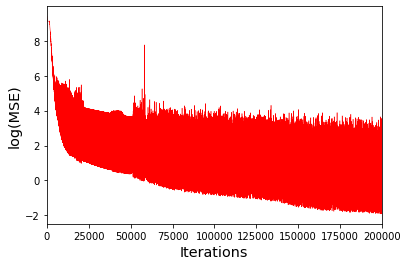

In [ ]:
plt.plot(np.array(np.log(pinn_loss_hist)), 'r', linewidth=0.5)
plt.xlabel('Iterations', fontsize='x-large')
plt.ylabel('$log(MSE)$', fontsize='x-large')
plt.xlim(0,iterations[-1])
plt.savefig('loss_history_pinn.png')
plt.show()

# Plot of final result

Text(0.5, 0, '$z$')

/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/proj3d.py:189: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/proj3d.py:189: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones_like(xs)])


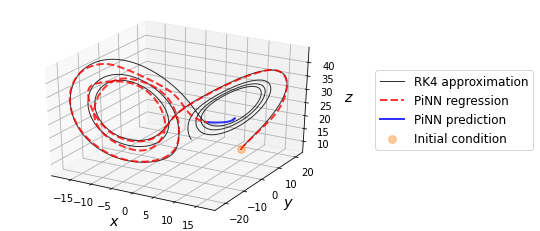

In [ ]:
# Plot of just the final PiNN prediction
n = 2000
tf = 5
t = torch.linspace(0,tf,n).view(-1,1).requires_grad_(True)
u_pred = pinn.forward(t)
x_pred,y_pred,z_pred = u_pred[:,0],u_pred[:,1],u_pred[:,2]
x_pred,y_pred,z_pred = x_pred.detach().numpy(),y_pred.detach().numpy(),z_pred.detach().numpy()
x,y,z = torch.FloatTensor(RungeKutta(dxdt_def,dydt_def,dzdt_def, x0,y0,z0, 0,tf,n))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x,y,z, color="black", linewidth=1, alpha=0.8, label="RK4 approximation")
ax.plot(x_pred[:1200],y_pred[:1200],z_pred[:1200], 'r--', linewidth=2, alpha=0.8, label="PiNN regression")
ax.plot(x_pred[1200:],y_pred[1200:],z_pred[1200:], 'b', linewidth=2, alpha=0.8, label="PiNN prediction")
ax.scatter(x0, y0, z0, s=60, color="tab:orange", alpha=0.4, label='Initial condition')
l = plt.legend(loc=(1.1,0.34), frameon=True, fontsize="large")
plt.setp(l.get_texts(), color="k")
ax.set_xlabel('$x$', fontsize="x-large")
ax.set_ylabel('$y$', fontsize="x-large")
ax.set_zlabel('$z$', fontsize="x-large")

# SAVES

In [ ]:
# Expected runtime: 1:07:21.151819
!mkdir PiNN_plots
torch.manual_seed(12345)
np.random.seed(12345)

class PINN(nn.Module):
  def __init__(self, t, layers, activation_fun=nn.Tanh):
    super(PINN, self).__init__()

    self.act_fun = activation_fun()

    self.hidden_layers = [nn.Linear(u_layers[0], u_layers[1])]
    for idx, width in enumerate(u_layers[1:-1]):
      if idx < (len(u_layers[1:-1]) - 1):
        self.hidden_layers.append(nn.Linear(width, u_layers[idx + 2]))

    self.output_layer = nn.Linear(u_layers[-2], u_layers[-1]) 
    self.fnn = self.layers()
    
  def forward(self, t):
      output = self.fnn(t)
      return output

  def layers(self):
      modules = []
      for idx, layer in enumerate(self.hidden_layers):
          modules.append(layer)
          modules.append(self.act_fun)
      modules.append(self.output_layer)
      return nn.Sequential(*modules)

PiNN_files = []
def plotting(pinn):
    t = torch.linspace(0,tf,n).view(-1,1).requires_grad_(True)
    u_pred = pinn.forward(t)
    x_pred,y_pred,z_pred = u_pred[:,0],u_pred[:,1],u_pred[:,2]
    x_pred,y_pred,z_pred = x_pred.detach().numpy(),y_pred.detach().numpy(),z_pred.detach().numpy()
    x,y,z = torch.FloatTensor(RungeKutta(dxdt_def,dydt_def,dzdt_def, x0,y0,z0, 0,tf,n))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(x,y,z, color="black", linewidth=1, alpha=0.8, label="RK4 approximation")
    index = int(regression_index/tf) #till what index is regressed on or from what is predicted
    ax.plot(x_pred[:index],y_pred[:index],z_pred[:index], 'r--', linewidth=2, alpha=0.8, label="PiNN regression")
    ax.plot(x_pred[index:],y_pred[index:],z_pred[index:], 'b', linewidth=2, alpha=0.8, label="PiNN prediction")
    ax.scatter(x0, y0, z0, s=60, color="tab:orange", alpha=0.4, label='Initial condition')
    l = plt.legend(loc=(1.1,0.34), frameon=True, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    ax.text2D(0.11, 0.07, "Training step: %i"%(i), fontsize="x-large", color="k")
    ax.text2D(0.11, 0.05, "Loss: {:.2e}".format(loss), fontsize="x-large", color="k")
    ax.text2D(0.11, -0.05, "$t_f$ = {:.2f}, $\\alpha$ = {:.1e}, $t_u$ = {:.1e}".format(tf, alpha, update_t), fontsize="x-large", color="k")
    ax.set_xlabel('$x$', fontsize="x-large")
    ax.set_ylabel('$y$', fontsize="x-large")
    ax.set_zlabel('$z$', fontsize="x-large")
    file = "PiNN_plots/pinn_%.6i.png"%(e)
    plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
    PiNN_files.append(file)
    plt.show()

# Used to create a iteratively gif-animation of the convergence ---------------
def save_gif(outfile, files, fps=5, loop=0):
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

# (Hyper)parameters of the training -------------------------------------------
lr = 0.001
u_layers = [1, 50,50,50,50, 3]
intermediate = 1000
tf = 4.0
n = 1000
regression_index = tf*n #as help to see calculate until which index the regression is performed
time = datetime.now()

t = torch.linspace(0,tf,n).view(-1,1).requires_grad_(True) #Time-list used in dynamic loss2 training
pinn = PINN(t, u_layers)
optimizer = torch.optim.Adam(pinn.parameters(),lr=lr) 
N_pred = model_ode.forward(t, model)
N_pred_x,N_pred_y,N_pred_z = N_pred[:,0],N_pred[:,1],N_pred[:,2]
N_pred_x,N_pred_y,N_pred_z = N_pred_x.view(-1,1),N_pred_y.view(-1,1),N_pred_z.view(-1,1)

# Some empty lists and starting conditions ------------------------------------
pinn_loss_hist = []
tf_list = []
iterations = 250000
e = 0 #Starting iteration because a while loop is used

# The following network makes in the training use of the time extension method -
for i in range(iterations): #Loop over the iterations (and stop when tf = 4.0 is reached and empirically converged)
    optimizer.zero_grad()

    #Calculation of loss1 that depends on the initial condition at t=0:
    m = pinn.forward(torch.FloatTensor([0]))
    xh,yh,zh = m[0],m[1],m[2]
    loss1 = torch.mean((xh-x0)**2 + (yh-y0)**2 + (zh-z0)**2)

    #Calculation of loss2 that depends on the dynamics of the system:
    p = pinn.forward(t_physics)
    px,py,pz = p[:,0],p[:,1],p[:,2]
    px,py,pz = px.view(-1,1),py.view(-1,1),pz.view(-1,1) #Correct shape
    dxdt = torch.autograd.grad(px, t_physics, torch.ones_like(px), create_graph=True)[0] #Calculate derivatives of output of PiNN w.r.t. t_physics
    dydt = torch.autograd.grad(py, t_physics, torch.ones_like(py), create_graph=True)[0]
    dzdt = torch.autograd.grad(pz, t_physics, torch.ones_like(pz), create_graph=True)[0]
    physics_x = N_pred_x - dxdt #Calculate f-residuals for the x,y,z differential equations
    physics_y = N_pred_y - dydt
    physics_z = N_pred_z - dzdt
    loss2 = torch.mean(physics_x**2 + physics_y**2 + physics_z**2) #Total loss2 is the MSE of above residuals

    loss = 10*loss1 + loss2 #Total loss with scaling factor of 10 for loss1 due to higher importance of initial condition w.r.t. the dynamic loss
    loss.backward(retain_graph=True)
    loss = loss.detach() #Otherwise the RAM blows up due to the retain_graph=True
    optimizer.step()
    pinn_loss_hist.append(loss) #Saving all loss values, for the plot in the next cell

    if i%intermediate == 0: #Plotting/printing intermediate results using the iterations list
        print("epoch = %6d" % i, end="")
        print("  epoch loss = %10.8f" % loss, end="")
        print("  time: {}".format(datetime.now() - time), end="")
        print("\n")
        plotting(pinn)

#Creating gif-animations:
save_gif("pinn_prediction.gif", PiNN_files, fps=20, loop=0)
#Saving the model:
torch.save(pinn.state_dict(), 'PINN_model_weights.pth')